# Expectation Maximization for for GMM

The main idea of EM algorithm: you want to maximize your marginal log likelihood to obtain the optimal parameters of the model to describe the data but it is hard to do this. Instead of this, we can build a variational lower bound which depends on original $\theta$ and variational parameters $q$. The lower bound is easy to maximize. Then we try to maximize this lower bound with respect to both $\theta$ and $q$. Our strategy is fix one and maximize the other.


In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Downloading Colab files")
    ! shred -u setup_google_colab.py
    ! wget https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.load_data_week2()

In [2]:
import numpy as np
from numpy.linalg import slogdet, det, solve
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_digits
%matplotlib inline

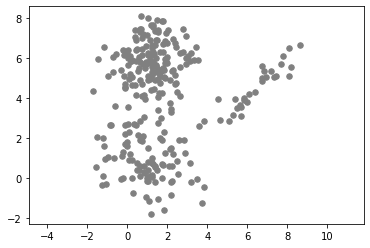

In [3]:
samples = np.load('samples.npz')
X = samples['data']
pi0 = samples['pi0']
mu0 = samples['mu0']
sigma0 = samples['sigma0']
plt.scatter(X[:, 0], X[:, 1], c='grey', s=30)
plt.axis('equal')
plt.show()

## E step

In this step we need to estimate the posterior distribution over the latent variables with fixed values of parameters.
Does Xi look like it came from cluster c?

In [8]:
from scipy.stats import multivariate_normal
def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0]       # number of samples
    C = pi.shape[0]      # number of clusters
    d = X.shape[1]                     # dimension of each sample
    gamma = np.zeros((N, C)) # distribution q(T)
    #print(N,C,d,gamma)
    # P(t|x)=p(x|t)p(t)/z
    # p(x|t)=N(mu,sigma)
    for c in range(C):
        gamma[:,c]=multivariate_normal.pdf(X, mean=mu[c,:], cov=sigma[c,...])*(pi[c])
    gamma = gamma/np.sum(gamma,1).reshape(-1,1) # axis = 1 summing along rows
    
    return gamma

In [10]:
gamma = E_step(X, pi0, mu0, sigma0)
print(gamma)

[[9.89984413e-001 1.00155874e-002 2.51121517e-016]
 [9.77802155e-001 2.21978447e-002 1.07229089e-014]
 [9.78228436e-001 2.17715636e-002 6.65282252e-016]
 [9.99470994e-001 5.29005851e-004 7.87626322e-024]
 [9.99482344e-001 5.17656126e-004 3.24388347e-026]
 [6.83857110e-005 9.99931614e-001 1.15852408e-020]
 [1.50729715e-036 1.00000000e+000 2.89692453e-057]
 [1.83115480e-001 8.16884375e-001 1.44924709e-007]
 [9.60027562e-001 3.99724376e-002 7.78636239e-013]
 [4.35705967e-001 5.33717874e-001 3.05761590e-002]
 [4.22427127e-001 5.74733674e-001 2.83919872e-003]
 [9.88286857e-001 1.17131434e-002 1.83043464e-016]
 [5.42939168e-001 4.56729246e-001 3.31586125e-004]
 [1.08502493e-001 8.91497507e-001 8.73826666e-032]
 [6.27715071e-004 9.99372285e-001 3.50074230e-024]
 [8.65821552e-001 1.34178197e-001 2.50489977e-007]
 [1.34635440e-010 1.00000000e+000 1.69888046e-010]
 [9.98574647e-001 1.42535271e-003 3.60305312e-021]
 [5.82682916e-001 4.17155213e-001 1.61870957e-004]
 [7.17431881e-003 9.92825681e-0

## M step

Update gaussian parameters to fit points assigned to them.

In [13]:
def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0]       # number of samples
    C = gamma.shape[1]      # number of clusters
    d = X.shape[1]                     # dimension of each sample
    
    
    mu = np.zeros((C, d))
    sigma = np.zeros((C, d, d))
    pi = np.sum(gamma, axis=0) / (1.0 * N)
    for i in range(C):      
      mu[i,:] = np.sum(X * gamma[:,i][:,np.newaxis], axis=0) / (pi[i]*N)
      X_i = X - mu[i, :][np.newaxis, :]  # Nxd-Dim
      sigma[i,:,:] = np.dot((X_i * gamma[:,i][:,np.newaxis]).T , X_i) / (pi[i]*N)

    return pi, mu, sigma

In [15]:
pi, mu, sigma = M_step(X, gamma)
print(pi)
print(mu)
print(sigma)

[0.44702322 0.55076245 0.00221433]
[[ 1.05852748  5.40759435]
 [ 2.16796132  2.89939188]
 [-1.33306197  1.41522785]]
[[[ 0.70631457  1.00189734]
  [ 1.00189734  3.09525744]]

 [[ 5.76353448  1.49049001]
  [ 1.49049001  5.97710522]]

 [[ 0.0676037  -0.21186747]
  [-0.21186747  3.29922798]]]


In [18]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound(loss function)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object
    
    loss = 0.0
    for k in range(C):
        PDF = multivariate_normal(mu[k], sigma[k],allow_singular=True)
        for n in range(N):
            loss += gamma[n,k]*(np.log(pi[k]+0.00001)+PDF.logpdf(X[n,:])-np.log(gamma[n,k]+0.000001))
    return loss

In [20]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
print(loss)

-1213.9656095336402


In [21]:
import math
def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = -float("inf")
    best_pi = None
    best_mu = None
    best_sigma = None

    for _ in range(restarts):
        try:
            pi = 1/float(C)*np.ones(C)
            mu = np.random.randn(C,d)
            sigma = np.zeros((C,d,d))
            sigma[...] = np.identity(d)
            prev_loss = None

            for _ in range(max_iter):
    
              gamma = E_step(X, pi, mu, sigma)
              pi, mu, sigma = M_step(X, gamma)
              loss = compute_vlb(X, pi, mu, sigma, gamma)
              if not math.isnan(loss) and loss > best_loss:
                best_loss = loss
                best_mu = mu
                best_pi = pi
                best_sigma = sigma
                
              if prev_loss is not None:
                  diff = np.abs(loss - prev_loss)
                  if diff < rtol:
                      break
              prev_loss = loss
              
        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass

    return best_loss, best_pi, best_mu, best_sigma

In [22]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X, 3)

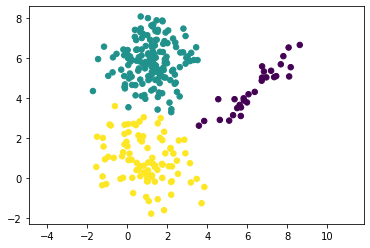

In [24]:
# plot the results
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30)
plt.axis('equal')
plt.show()